In [74]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SEIR_stochastic, plot_samples, plot_forecast, plot_R0
import util

# Run Inference

In [94]:
data = util.load_state_data()

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
#places = ['US']
places = ['AL']
#places = ['NY', 'WA']


for place in places:
    util.run_place(data, place, use_hosp=True, save=save, num_warmup=100, num_samples=100)


******* AL *********
Running MCMC


sample: 100%|██████████| 200/200 [00:47<00:00,  4.18it/s, 157 steps of size 1.03e-02. acc. prob=0.71]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         E0      0.08      0.11      0.04      0.00      0.24     32.52      1.03
         I0      0.04      0.04      0.03      0.00      0.08     45.78      1.01
    beta[0]      3.02      1.45      2.72      1.42      5.17     16.12      0.99
    beta[1]      3.11      1.58      2.66      1.25      5.56     23.77      0.99
    beta[2]      3.29      1.48      3.04      1.26      5.31     41.21      0.99
    beta[3]      3.80      1.84      3.38      1.72      6.05     87.07      1.00
    beta[4]      4.35      1.90      3.93      2.15      7.03     77.95      1.00
    beta[5]      4.86      2.38      4.41      2.21      7.19     77.66      1.00
    beta[6]      5.47      2.56      4.77      2.02      8.57     73.69      1.00
    beta[7]      5.79      2.54      5.29      3.24      9.80     66.23      1.00
    beta[8]      5.84      2.46      5.31      2.55      9.59     65.25      1.00
    beta[9]    

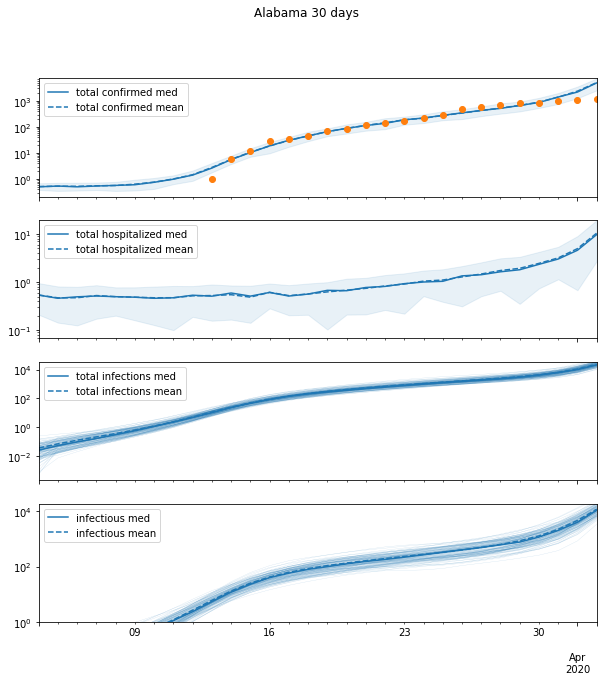

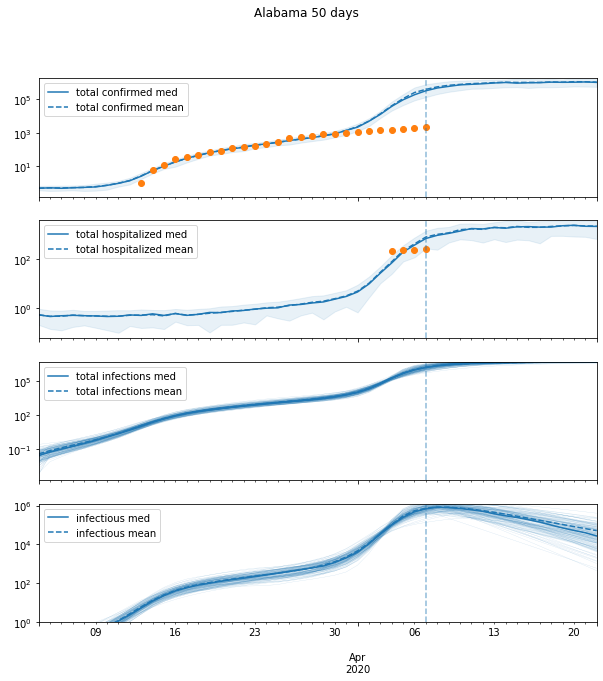

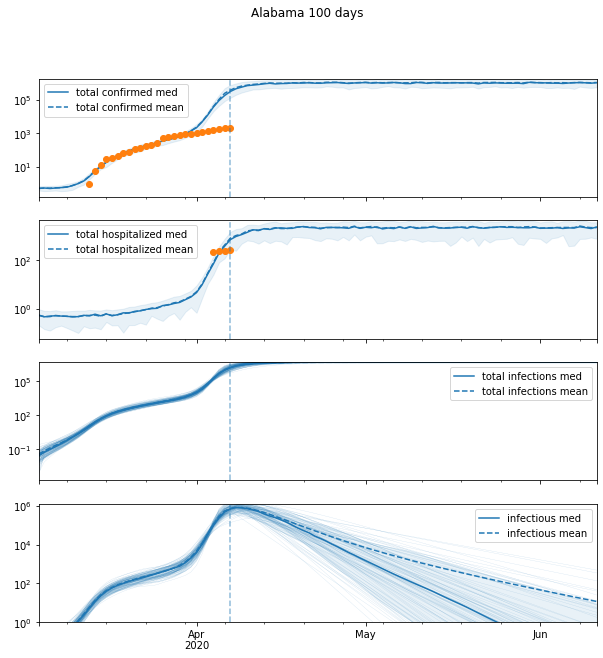

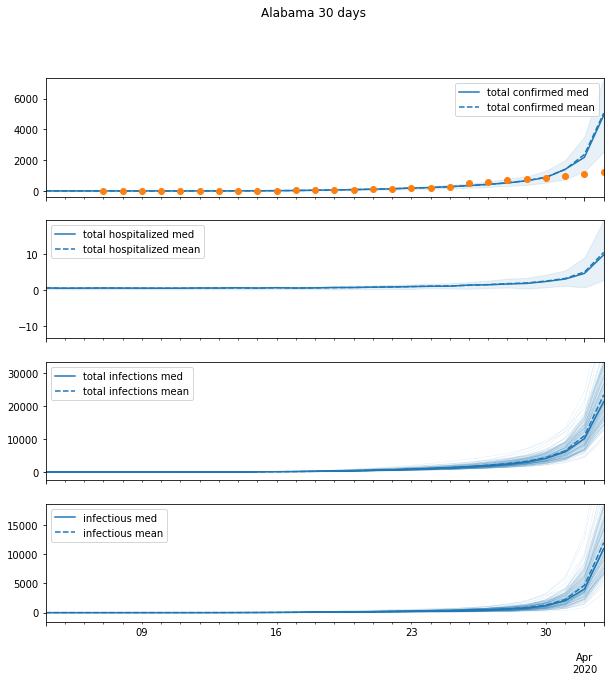

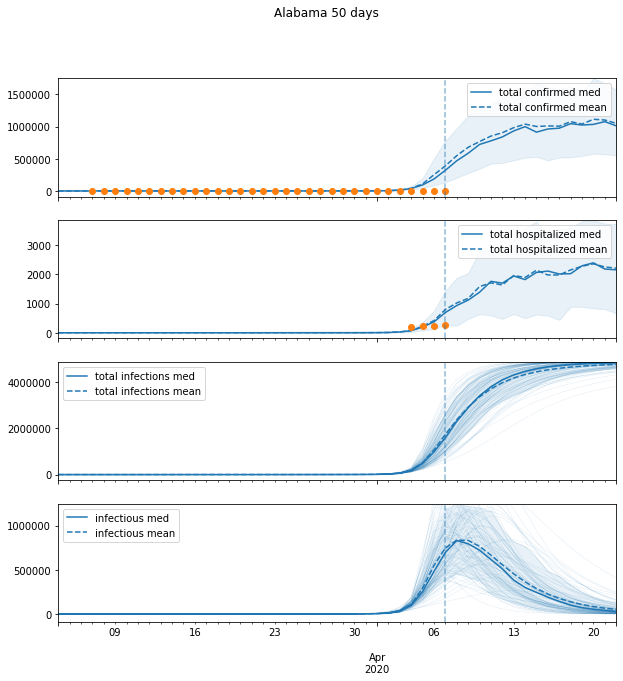

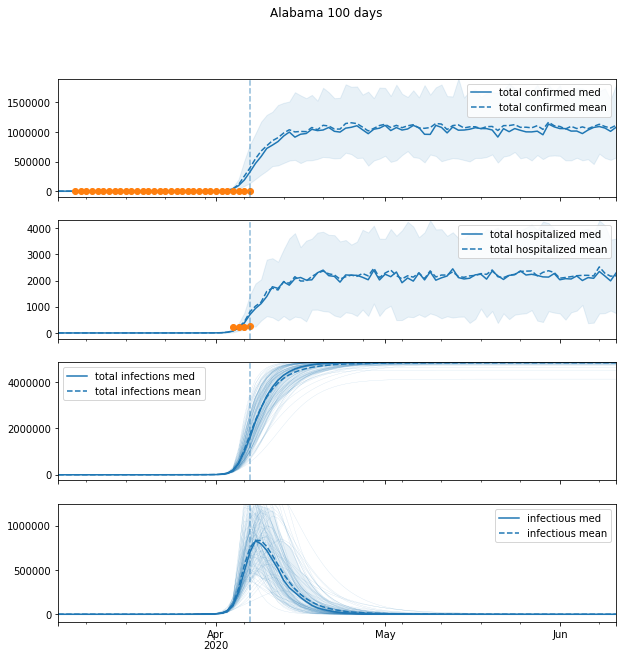

<Figure size 360x216 with 0 Axes>

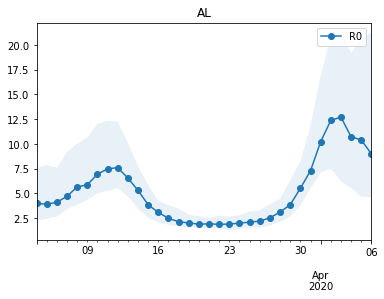

In [95]:
data = util.load_state_data()

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
places = ['NY']
#places = state_data.keys()
#places = ['AK']
#places = ['US']
#places = ['LA', 'NY']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
places = ['AL']

use_hosp = True
save = True


# Inspect and Save Results 
for place in places:
    util.gen_forecasts(data, place, use_hosp=use_hosp, save=save)

0.1341772151898734

In [ ]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

In [ ]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [ ]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

In [ ]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

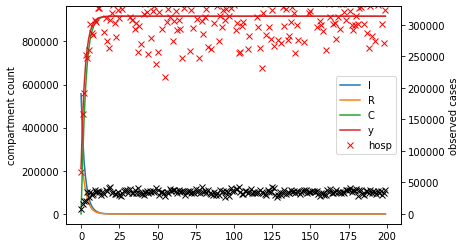

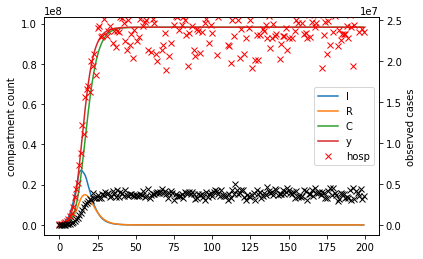

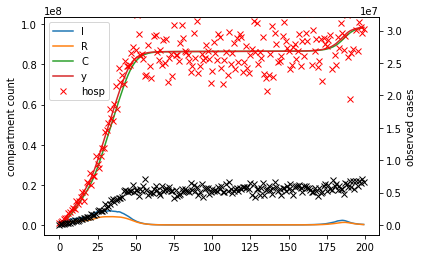

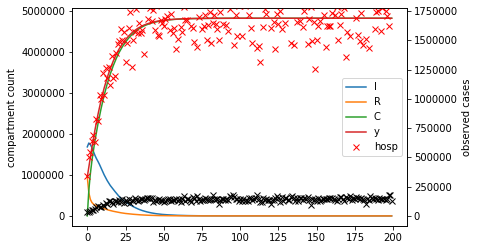

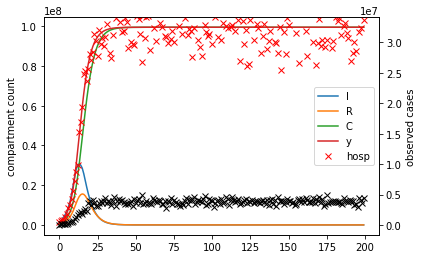

In [56]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, z, obs_rate, hosp_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x[:,1:])    
    l2 = ax2.plot(ts, y, 'x', color='r')
    l3 = ax2.plot(ts, z, 'x', color='k')
        
    plt.legend(l1 + l2 + l3, ['I', 'R', 'C', 'y', 'hosp'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N, det_conc=200)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=100, T_future=100, N=1e8, use_hosp=True)
        
#    samples = test_prior_predictive()

In [ ]:
# Observation distribution
conc = 10

x = np.linspace(0, 1, 1000)

for N in ([10, 100, 1e4, 1e5, 1e6, 1e6, 1e8]):
    
    adj_conc = conc * N**0.2 * 10
    
    for p in np.linspace(0.01, 0.99, 10):
        d = dist.Beta(adj_conc*p, adj_conc*(1-p))
        plt.plot(N*x, np.exp(d.log_prob(x)))
    
    plt.show()


In [34]:
a, b, c, \
d, e = 1, 2, 3, 4, 5
print(a, b, c, d, e)

1 2 3 4 5
